In [31]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split # Can be used for initial split if careful
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping # Optional

# Load the dataset
df = pd.read_csv('baraj_seviyesi_tum_yillar_eksiksiz.csv', index_col=0, parse_dates=True)

# Keep only the target variable for univariate forecasting initially
# (You can add features later)
df_lstm = df[['Baraj_Seviyesi']].copy()

In [32]:
# Scale the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df_lstm)

# Keep the scaler object
# scaler will be used later for inverse transformation

In [33]:
# Define sequence length
sequence_length = 30 # Look back 30 days to predict the next day

X_seq, y_seq = [], []
for i in range(sequence_length, len(scaled_data)):
    X_seq.append(scaled_data[i-sequence_length:i, 0]) # Input sequence
    y_seq.append(scaled_data[i, 0]) # Target value (next day)

X_seq, y_seq = np.array(X_seq), np.array(y_seq)

# Reshape X for LSTM input: [samples, time steps, features]
# In this univariate case, features = 1
X_seq = np.reshape(X_seq, (X_seq.shape[0], X_seq.shape[1], 1))

In [34]:
# Define split point (e.g., 85% for training)
train_size = int(len(X_seq) * 0.85)
# val_size = int(len(X_seq) * 0.10) # Optional validation set size

X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

# Optional: Further split training for validation
# X_train, X_val = X_train[:train_size-val_size], X_train[train_size-val_size:]
# y_train, y_val = y_train[:train_size-val_size], y_train[train_size-val_size:]

print(f"Training sequences: {X_train.shape}")
print(f"Testing sequences: {X_test.shape}")
# print(f"Validation sequences: {X_val.shape}") # If using validation set

Training sequences: (2861, 30, 1)
Testing sequences: (505, 30, 1)


In [35]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(sequence_length, 1)))
model.add(Dropout(0.2)) # Dropout for regularization
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25)) # Optional intermediate dense layer
model.add(Dense(units=1)) # Output layer

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary() # Print model architecture

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 30, 50)            10400     
                                                                 
 dropout_8 (Dropout)         (None, 30, 50)            0         
                                                                 
 lstm_9 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_9 (Dropout)         (None, 50)                0         
                                                                 
 dense_8 (Dense)             (None, 25)                1275      
                                                                 
 dense_9 (Dense)             (None, 1)                 26        
                                                                 
Total params: 31,901
Trainable params: 31,901
Non-trai

Training LSTM model...
Epoch 1/50
90/90 [==============================] - 3s 11ms/step - loss: 0.0332
Epoch 2/50
90/90 [==============================] - 1s 10ms/step - loss: 0.0077
Epoch 3/50
90/90 [==============================] - 1s 10ms/step - loss: 0.0058
Epoch 4/50
90/90 [==============================] - 1s 10ms/step - loss: 0.0048
Epoch 5/50
90/90 [==============================] - 1s 10ms/step - loss: 0.0040
Epoch 6/50
90/90 [==============================] - 1s 10ms/step - loss: 0.0038
Epoch 7/50
90/90 [==============================] - 1s 10ms/step - loss: 0.0036
Epoch 8/50
90/90 [==============================] - 1s 10ms/step - loss: 0.0034
Epoch 9/50
90/90 [==============================] - 1s 10ms/step - loss: 0.0032
Epoch 10/50
90/90 [==============================] - 1s 10ms/step - loss: 0.0028
Epoch 11/50
90/90 [==============================] - 1s 10ms/step - loss: 0.0026
Epoch 12/50
90/90 [==============================] - 1s 9ms/step - loss: 0.0024
Epoch 13/50
90/

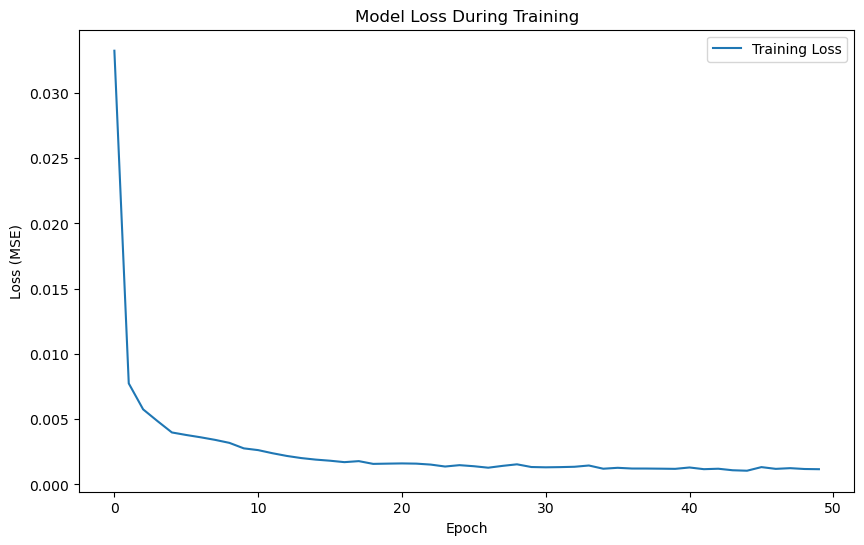

In [36]:
# Optional: Define Early Stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
print("Training LSTM model...")
history = model.fit(
    X_train, y_train,
    batch_size=32, # Adjust batch size as needed
    epochs=50,    # Adjust epochs as needed
    # validation_data=(X_val, y_val), # Uncomment if using validation set
    # callbacks=[early_stopping],      # Uncomment if using early stopping
    verbose=1 # Set to 2 for less output per epoch, 0 for silent
)
print("Training complete.")

# Optional: Plot training history
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

In [37]:
# Make predictions on test data
y_pred_scaled = model.predict(X_test)

# Inverse transform predictions and actual values
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

16/16 [==============================] - 1s 5ms/step


Test RMSE: 0.5437
Test MAE: 0.4159
Test MAPE: 0.29%
R² Score: 0.9980
Explained Variance: 0.9985


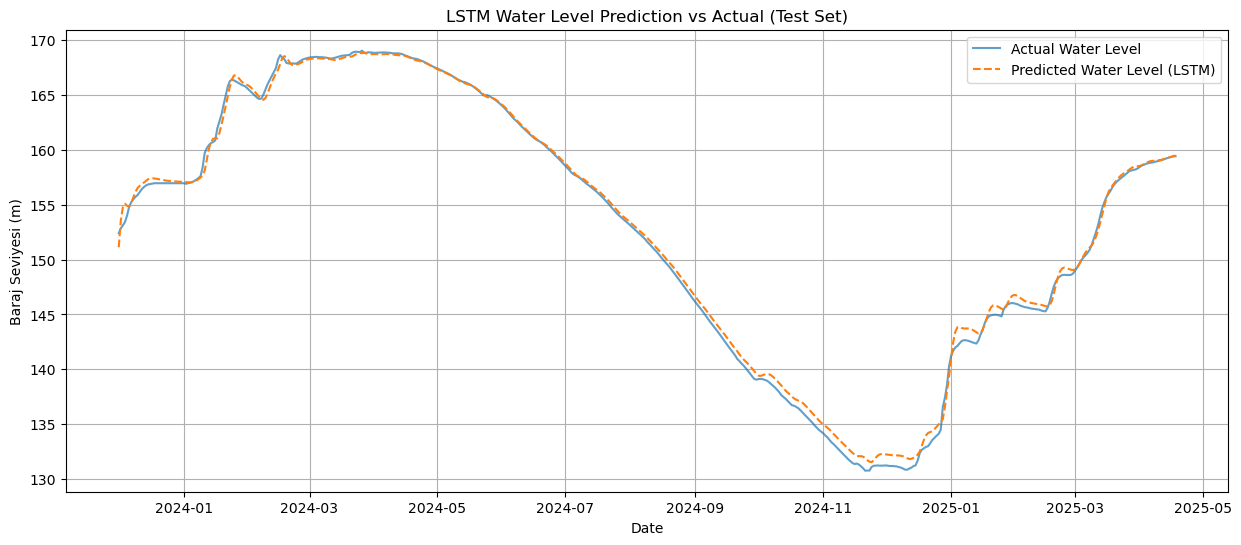

In [40]:
# Calculate metrics on original scale
from sklearn.metrics import r2_score, explained_variance_score


rmse = np.sqrt(mean_squared_error(y_test_actual, y_pred))
mae = mean_absolute_error(y_test_actual, y_pred)
mape = np.mean(np.abs((y_test_actual - y_pred) / y_test_actual)) * 100
r2 = r2_score(y_test_actual, y_pred)
explained_variance = explained_variance_score(y_test_actual, y_pred)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"R² Score: {r2:.4f}")
print(f"Explained Variance: {explained_variance:.4f}")

# Get the correct dates for the test set plotting
test_dates = df_lstm.index[train_size+sequence_length:] # Adjust index based on split

# Visualize predictions vs actuals
plt.figure(figsize=(15, 6))
plt.plot(test_dates, y_test_actual, label='Actual Water Level', alpha=0.7)
plt.plot(test_dates, y_pred, label='Predicted Water Level (LSTM)', linestyle='--')
plt.title('LSTM Water Level Prediction vs Actual (Test Set)')
plt.xlabel('Date')
plt.ylabel('Baraj Seviyesi (m)')
plt.legend()
plt.grid(True)
plt.show()